<a href="https://colab.research.google.com/github/swilsonmfc/bias_variance/blob/main/FeatureSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Selection

![](https://benthamopen.com/contents/figures/TOBIOIJ/TOBIOIJ-11-117_F3.jpg)

# Install

In [33]:
!pip install feature_engine

# Setup

In [110]:
import math
import pandas as pd
import numpy as np
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from feature_engine.encoding import OneHotEncoder

In [35]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

# Kaggle

In [36]:
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


# Data

In [37]:
!kaggle competitions download -c allstate-claims-severity

test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [38]:
!unzip train.csv.zip 

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [39]:
df = pd.read_csv('train.csv', warn_bad_lines=False, error_bad_lines=False)
df.shape

(188319, 132)

# EDA

In [40]:
df.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1.0,A,B,A,B,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,D,B,B,D,D,B,D,C,B,D,B,A,A,A,A,A,D,B,C,E,A,C,T,B,G,A,A,I,E,G,J,G,BU,BC,C,AS,S,A,O,LB,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2.0,A,B,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,D,D,A,B,C,B,D,B,A,A,A,A,A,D,D,C,E,E,D,T,L,F,A,A,E,E,I,K,K,BI,CQ,A,AV,BM,A,O,DP,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5.0,A,B,A,A,B,A,A,A,B,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,B,D,B,D,C,B,B,B,A,A,A,A,A,D,D,C,E,E,A,D,L,O,A,B,E,F,H,F,A,AB,DK,A,C,AF,A,I,GK,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10.0,B,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,D,B,B,D,D,D,B,C,B,D,B,A,A,A,A,A,D,D,C,E,E,D,T,I,D,A,A,E,E,I,K,K,BI,CS,C,N,AE,A,O,DJ,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11.0,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,D,B,D,B,D,B,B,C,B,B,C,A,A,A,B,H,D,B,D,E,E,A,P,F,J,A,A,D,E,K,G,B,H,C,C,Y,BM,A,K,CK,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [41]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188319 entries, 0 to 188318
Data columns (total 132 columns):
 #   Column  Dtype  
---  ------  -----  
 0   id      float64
 1   cat1    object 
 2   cat2    object 
 3   cat3    object 
 4   cat4    object 
 5   cat5    object 
 6   cat6    object 
 7   cat7    object 
 8   cat8    object 
 9   cat9    object 
 10  cat10   object 
 11  cat11   object 
 12  cat12   object 
 13  cat13   object 
 14  cat14   object 
 15  cat15   object 
 16  cat16   object 
 17  cat17   object 
 18  cat18   object 
 19  cat19   object 
 20  cat20   object 
 21  cat21   object 
 22  cat22   object 
 23  cat23   object 
 24  cat24   object 
 25  cat25   object 
 26  cat26   object 
 27  cat27   object 
 28  cat28   object 
 29  cat29   object 
 30  cat30   object 
 31  cat31   object 
 32  cat32   object 
 33  cat33   object 
 34  cat34   object 
 35  cat35   object 
 36  cat36   object 
 37  cat37   object 
 38  cat38   object 
 39  cat39   object 
 40  c

In [45]:
df = df.dropna()
df.shape

(188318, 132)

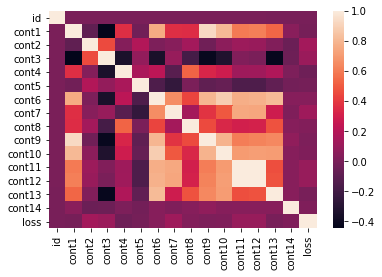

In [111]:
sns.heatmap(df.corr())

# Pipeline

In [47]:
data = df[0:5000].copy()
y = data['loss']
X = data.drop(columns=['loss', 'id'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=251)

In [48]:
catColumns = X_train.select_dtypes(include='object').columns.tolist()
numColumns = X_train.select_dtypes(include='number').columns.tolist()

In [50]:
X_train_num = X_train[numColumns]
X_test_num  = X_test[numColumns]

X_train_cat = X_train[catColumns]
X_test_cat  = X_test[catColumns]

scaler = StandardScaler()
ohe    = OneHotEncoder(variables=catColumns)

X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns = X_train_num.columns)
X_train_num = X_train_num.reset_index(drop=True)
X_test_num  = pd.DataFrame(scaler.transform(X_test_num), columns = X_train_num.columns)
X_test_num = X_test_num.reset_index(drop=True)

X_train_cat = ohe.fit_transform(X_train_cat)
X_train_cat = X_train_cat.reset_index(drop=True)
X_test_cat  = ohe.transform(X_test_cat)
X_test_cat  = X_test_cat.reset_index(drop=True)

X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test  = pd.concat([X_test_num, X_test_cat], axis=1)

# Loss

In [51]:
def evaluate(truth, pred):
    mae  = mean_absolute_error(truth, pred)
    mse  = mean_squared_error(truth, pred)
    rmse = math.sqrt(mse)
    return (mae, mse, rmse)

results_df = pd.DataFrame(columns=['Technique', 'Method', 'MAE', 'RMSE', 'Features'])

# Baseline

In [78]:
rf = RandomForestRegressor(random_state=1337)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
mae, mse, rmse = evaluate(y_test, pred)
print('MAE  : {:.2f}'.format(mae))
print('RMSE : {:.2f}'.format(rmse))
results_df.loc['Baseline'] = ['None', 'Baseline', mae, rmse, X_train.shape[1]]

MAE  : 1365.87
RMSE : 2080.47


# Filter

## Highly Correlated
* Highly correlated features can lead to overfitting
* We can remove highly correlated variables without the loss of much information
* EDA indicated:
  * cont12 and cont11 highly correlated
  * cont9 and cont1 highly correlated

In [79]:
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
features_to_remove = [column for column in upper.columns if any(upper[column] > 0.95)]

In [80]:
print(features_to_remove) # Note 0.95 > Cont9 > 0.90
X_train_new = X_train.drop(columns=features_to_remove, axis=1)
X_test_new = X_test.drop(columns=features_to_remove, axis=1)

['cont12', 'cat1_B', 'cat2_A', 'cat3_B', 'cat4_B', 'cat5_B', 'cat6_B', 'cat7_A', 'cat8_A', 'cat9_A', 'cat10_A', 'cat11_A', 'cat12_A', 'cat13_A', 'cat14_B', 'cat16_B', 'cat17_B', 'cat18_B', 'cat19_B', 'cat20_B', 'cat21_B', 'cat22_B', 'cat23_B', 'cat24_B', 'cat25_B', 'cat26_B', 'cat27_B', 'cat28_B', 'cat29_B', 'cat30_B', 'cat31_B', 'cat32_B', 'cat33_B', 'cat34_B', 'cat35_B', 'cat36_B', 'cat37_B', 'cat38_B', 'cat39_B', 'cat40_B', 'cat41_B', 'cat42_B', 'cat43_B', 'cat44_B', 'cat45_B', 'cat46_B', 'cat47_B', 'cat48_B', 'cat49_B', 'cat50_B', 'cat51_B', 'cat52_B', 'cat53_B', 'cat54_B', 'cat55_B', 'cat56_B', 'cat57_A', 'cat58_B', 'cat59_B', 'cat60_B', 'cat61_B', 'cat62_B', 'cat64_B', 'cat65_B', 'cat66_A', 'cat67_B', 'cat68_B', 'cat69_B', 'cat71_B', 'cat72_A', 'cat73_B', 'cat74_B', 'cat75_A', 'cat76_B', 'cat78_A', 'cat80_A', 'cat81_A', 'cat85_A', 'cat87_A', 'cat88_A', 'cat89_B', 'cat89_A', 'cat89_E', 'cat90_A', 'cat90_B', 'cat90_F', 'cat92_H', 'cat93_C', 'cat98_A', 'cat98_E', 'cat99_T', 'cat99_P

In [81]:
# Predict & Score
rf = RandomForestRegressor(random_state=202)
rf.fit(X_train_new, y_train)
pred = rf.predict(X_test_new)
mae, mse, rmse = evaluate(y_test, pred)
print('MAE  : {:.2f}'.format(mae))
print('RMSE : {:.2f}'.format(rmse))
results_df.loc['Filter:Correlated'] = ['Filter', 'Correlated', mae, rmse, X_train_new.shape[1]]

MAE  : 1360.29
RMSE : 2080.11


## Select Percentile
* Univariate Method
* Choose your scoring method
  * F-Value between label / feature
  * Mutual Information
* Other selection apporaches
  * Select K Best (fixed number)
  * Select From Model (choose from importance or coefficients)

## F Score - Regression
* Use a linear model for testing the individual effect of a regressor
* Scoring function:
  * Correlation between regressor & target computed
  * Convert to F score
  * Convert to p-value
  * Take top (n) or percentile of features
* For this example. pick upper 10th percentile (~80 features)

In [82]:
selector = SelectPercentile(f_regression, percentile=10)
selector.fit(X_train, y_train)
X_train_new = selector.transform(X_train)
X_test_new = selector.transform(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


In [83]:
cols   = X_train.columns[selector.get_support()]
pvals  = selector.pvalues_[selector.get_support()]
scores = -np.log10(pvals)
scores /= scores.max()
features_freg_df = pd.DataFrame({'Column': cols, 'P-Value': pvals, 'Score': scores})
features_freg_df.sort_values('Score', ascending=False)
features_freg_df = features_freg_df.reset_index(drop=True)
features_freg_df['Rank'] = features_freg_df.index + 1
features_freg_df.head()

,Column,P-Value,Score,Rank
0,cont2,6.479934e-18,0.071066,1
1,cont3,5.117963e-17,0.067355,2
2,cont7,1.821179e-19,0.077480,3
3,cont11,3.057156e-15,0.060012,4
4,cont12,7.965805e-16,0.062427,5


In [84]:
# Predict & Score
rf = RandomForestRegressor(random_state=999)
rf.fit(X_train_new, y_train)
pred = rf.predict(X_test_new)
mae, mse, rmse = evaluate(y_test, pred)
print('MAE  : {:.2f}'.format(mae))
print('RMSE : {:.2f}'.format(rmse))
results_df.loc['Filter:F-Score'] = ['Filter', 'F-Score', mae, rmse, X_train_new.shape[1]]

MAE  : 1438.92
RMSE : 2165.38


## Mutual Information
* Mutual information measues how much a random variable tells us about another
* For example, knowing wind speed could help us guess if a flight will be delayed
  * It won't tell us perfectly
  * But it could make our guess better
  * The degree to to which our guess is better are explained / measured with mutual information
* Note:
  * Mutual information is not correlation
  * Mutual information is more like information gain
  * Mutual information is a distance between probability distributions
  * Correlation measures the linear relationship between two random variables
* In this example, pick upper 10th percentile (about 80 features)

In [85]:
selector = SelectPercentile(mutual_info_regression, percentile=10)
selector.fit(X_train, y_train)
X_train_new = selector.transform(X_train)
X_test_new = selector.transform(X_test)

In [86]:
cols   = X_train.columns[selector.get_support()]
scores = selector.scores_[selector.get_support()]
scores /= scores.max()
features_mut_df = pd.DataFrame({'Column': cols, 'Score': scores})
features_mut_df.sort_values('Score', ascending=False)
features_mut_df = features_mut_df.reset_index(drop=True)
features_mut_df['Rank'] = features_mut_df.index + 1
features_mut_df.head()

,Column,Score,Rank
0,cont2,0.207214,1
1,cont3,0.094443,2
2,cont5,0.101913,3
3,cont7,0.155535,4
4,cont10,0.116205,5


In [87]:
# Predict & Score
rf = RandomForestRegressor()
rf.fit(X_train_new, y_train)
pred = rf.predict(X_test_new)
mae, mse, rmse = evaluate(y_test, pred)
print('MAE  : {:.2f}'.format(mae))
print('RMSE : {:.2f}'.format(rmse))
results_df.loc['Filter:MutualInformation'] = ['Filter', 'Mutual Information', mae, rmse, X_train_new.shape[1]]

MAE  : 1426.22
RMSE : 2155.32


## Comparison

In [88]:
combine_reg_df = features_freg_df[['Column', 'Score', 'Rank']]
combine_reg_df = combine_reg_df.rename(columns={'Score': 'FReg:Score', 'Rank':'FReg:Rank'})
combine_mut_df = features_mut_df[['Column', 'Score', 'Rank']]
combine_mut_df = combine_mut_df.rename(columns={'Score': 'Mut:Score', 'Rank':'Mut:Rank'})

features_df = pd.merge(left=combine_reg_df, right=combine_mut_df, how='outer',
                      left_on='Column', right_on='Column')
features_df

,Column,FReg:Score,FReg:Rank,Mut:Score,Mut:Rank
0,cont2,0.071066,1.0,0.207214,1.0
1,cont3,0.067355,2.0,0.094443,2.0
2,cont7,0.077480,3.0,0.155535,4.0
3,cont11,0.060012,4.0,NaN,NaN
4,cont12,0.062427,5.0,0.102656,6.0
5,cat1_A,0.170950,6.0,0.255856,8.0
6,cat1_B,0.170950,7.0,0.255856,9.0
7,cat2_B,0.188197,8.0,0.225855,10.0
8,cat2_A,0.188197,9.0,0.225855,11.0
9,cat3_A,0.144430,10.0,0.114812,12.0


## Variance Threshold

In [89]:
selector = VarianceThreshold()
selector.fit(X_train)
selector.get_support()
X_train_new = selector.transform(X_train)
X_test_new  = selector.transform(X_test)

In [90]:
# Predict & Score
rf = RandomForestRegressor(random_state=1337)
rf.fit(X_train_new, y_train)
pred = rf.predict(X_test_new)
mae, mse, rmse = evaluate(y_test, pred)
print('MAE  : {:.2f}'.format(mae))
print('RMSE : {:.2f}'.format(rmse))
results_df.loc['Filter:VarianceThreshold'] = ['Filter', 'VarianceThreshold', mae, rmse, X_train_new.shape[1]]

MAE  : 1368.46
RMSE : 2097.57


# Embedded
* Embedded method use a model to locate the best features.
* Broad approaches
  * Sparsity - Lasso
  * Importance - Random Forest
  * Coefficients - Linear Models, SVC / SVR (different than zero)

## Lasso Regression

In [91]:
lassoReg = Lasso(fit_intercept=False)
lassoReg.fit(X_train, y_train)
coefficients = lassoReg.coef_

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 793705974.5595188, tolerance: 7094203.34848626
  positive)


In [92]:
support = coefficients > 0
cols = X_train.columns[support]
X_train_new = X_train[cols]
X_test_new = X_test[cols]

In [93]:
# Predict & Score
rf = RandomForestRegressor(random_state=999)
rf.fit(X_train_new, y_train)
pred = rf.predict(X_test_new)
mae, mse, rmse = evaluate(y_test, pred)
print('MAE  : {:.2f}'.format(mae))
print('RMSE : {:.2f}'.format(rmse))
results_df.loc['Embedded:Lasso'] = ['Embedded', 'Lasso', mae, rmse, X_train_new.shape[1]]

MAE  : 1367.01
RMSE : 2101.34


## RandomForest Importance
* Common to fit a random forest to look at importance

In [94]:
estimator = RandomForestRegressor(random_state=1337)
selector = SelectFromModel(estimator, )
selector.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                                criterion='mse', max_depth=None,
                                                max_features='auto',
                                                max_leaf_nodes=None,
                                                max_samples=None,
                                                min_impurity_decrease=0.0,
                                                min_impurity_split=None,
                                                min_samples_leaf=1,
                                                min_samples_split=2,
                                                min_weight_fraction_leaf=0.0,
                                                n_estimators=100, n_jobs=None,
                                                oob_score=False,
                                                random_state=1337, verbose=0,
                                                war

In [95]:
cols = X_train.columns[(selector.get_support())]
X_train_new = X_train[cols]
X_test_new  = X_test[cols]

In [96]:
# Predict & Score
rf = RandomForestRegressor(random_state=999)
rf.fit(X_train_new, y_train)
pred = rf.predict(X_test_new)
mae, mse, rmse = evaluate(y_test, pred)
print('MAE  : {:.2f}'.format(mae))
print('RMSE : {:.2f}'.format(rmse))
results_df.loc['Embedded:RandomForest'] = ['Embedded', 'RandomForest', mae, rmse, X_train_new.shape[1]]

MAE  : 1372.25
RMSE : 2080.25


In [97]:
features = {}
for feature, importance in zip(X_train_new.columns, rf.feature_importances_):
    features[feature] = importance
importanceDF = pd.DataFrame.from_dict(features, orient='index')
importanceDF.sort_values(by=0, ascending=False).head(10)

,0
cat80_B,0.242401
cont2,0.052100
cont7,0.051350
cont14,0.043476
cont3,0.037110
cat57_A,0.023621
cont8,0.022725
cont11,0.022408
cont4,0.021076
cont12,0.020660


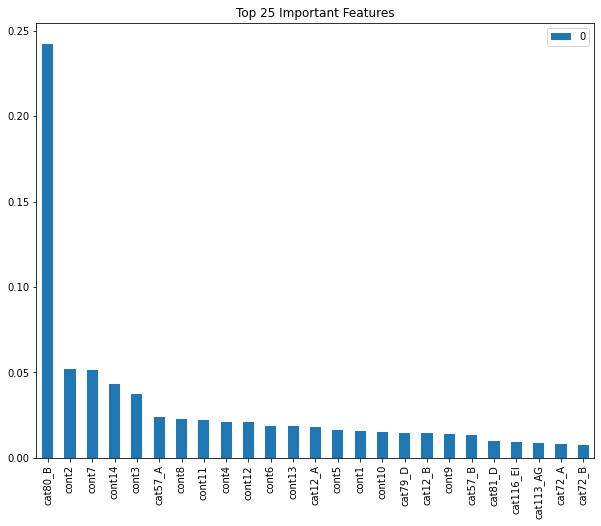

In [98]:
importanceDF.sort_values(by=0, ascending=False)[0:25].plot(kind='bar', rot=90, figsize=(10, 8))
plt.title('Top 25 Important Features');

# Wrapper

## Recursive Feature Elimination
* We start with a full model (all features)
* We then remove one feature and construct a model
* Greedily select the model with the lowest error
* Repeat until desired number of features or precisin is met

In [99]:
estimator = SVR(kernel="linear")
selector = RFE(estimator, 80, step=10, verbose=1)
selector = selector.fit(X_train, y_train)

Fitting estimator with 828 features.
Fitting estimator with 818 features.
Fitting estimator with 808 features.
Fitting estimator with 798 features.
Fitting estimator with 788 features.
Fitting estimator with 778 features.
Fitting estimator with 768 features.
Fitting estimator with 758 features.
Fitting estimator with 748 features.
Fitting estimator with 738 features.
Fitting estimator with 728 features.
Fitting estimator with 718 features.
Fitting estimator with 708 features.
Fitting estimator with 698 features.
Fitting estimator with 688 features.
Fitting estimator with 678 features.
Fitting estimator with 668 features.
Fitting estimator with 658 features.
Fitting estimator with 648 features.
Fitting estimator with 638 features.
Fitting estimator with 628 features.
Fitting estimator with 618 features.
Fitting estimator with 608 features.
Fitting estimator with 598 features.
Fitting estimator with 588 features.
Fitting estimator with 578 features.
Fitting estimator with 568 features.
F

In [100]:
X_train_new = selector.transform(X_train)
X_test_new  = selector.transform(X_test)

In [101]:
# Predict & Score
rf = RandomForestRegressor(random_state=999)
rf.fit(X_train_new, y_train)
pred = rf.predict(X_test_new)
mae, mse, rmse = evaluate(y_test, pred)
print('MAE  : {:.2f}'.format(mae))
print('RMSE : {:.2f}'.format(rmse))
results_df.loc['Wrapper:RFE'] = ['Wrapper', 'RFE', mae, rmse, X_train_new.shape[1]]

MAE  : 1399.74
RMSE : 2108.81


## Sequential Forward Selection
* There isn't a forward selection in sklearn
* The mlxtend library has a robust implementation
  * Parallel
  * Plotting
  * Target range
  * Includes float (https://www.sciencedirect.com/science/article/pii/0167865594901279)
* With SFS we start with an empty model
* Build a separate model for each additional feature
* Greedily select best model
* Repeat until desired number of features or precision reached

In [102]:
estimator = LinearRegression()
sfs = SFS(estimator,
         k_features=80,
         forward=True,
         floating=False,
         verbose=2,
         scoring='neg_mean_squared_error',
         n_jobs=-1,
         cv=0)

In [103]:
sfsModel = sfs.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 828 out of 828 | elapsed:    2.2s finished

[2021-06-30 18:45:14] Features: 1/80 -- score: -6416706.87302631[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 785 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 824 out of 827 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 827 out of 827 | elapsed:    0.9s finished

[2021-06-30 18:45:15] Features: 2/80 -- score: -5980323.971271509[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 785 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 826 out of 826 | elapsed:    1.0s finished

[2021-06-30 18:45:16] Features: 3/80 -- score: -5644577.549045111[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


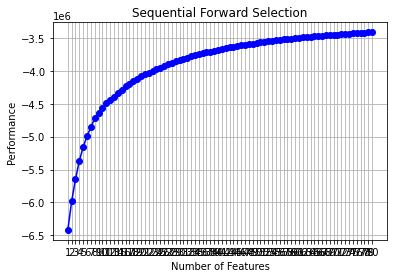

In [105]:
plot_sfs(sfsModel.get_metric_dict())
plt.title('Sequential Forward Selection')
plt.grid()
plt.show()

In [106]:
features = list(sfsModel.subsets_[80]['feature_names'])
X_train_new = X_train[features]
X_test_new  = X_test[features]

In [107]:
# Predict & Score
rf = RandomForestRegressor(random_state=999)
rf.fit(X_train_new, y_train)
pred = rf.predict(X_test_new)
mae, mse, rmse = evaluate(y_test, pred)
print('MAE  : {:.2f}'.format(mae))
print('RMSE : {:.2f}'.format(rmse))
results_df.loc['Wrapper:SFS'] = ['Wrapper', 'SFS', mae, rmse, X_train_new.shape[1]]

MAE  : 1370.59
RMSE : 2106.83


# Results

In [109]:
results_df['MAE/Feature'] = results_df.MAE / results_df.Features
results_df.sort_values('MAE', ascending=True)

,Technique,Method,MAE,RMSE,Features,MAE/Feature
Filter:Correlated,Filter,Correlated,1360.290502,2080.110845,711,1.91321
Baseline,None,Baseline,1365.874574,2080.472346,828,1.64961
Embedded:Lasso,Embedded,Lasso,1367.010946,2101.341022,218,6.27069
Filter:VarianceThreshold,Filter,VarianceThreshold,1368.460707,2097.571705,825,1.65874
Wrapper:SFS,Wrapper,SFS,1370.588298,2106.831427,80,17.1324
Embedded:RandomForest,Embedded,RandomForest,1372.251590,2080.247835,119,11.5315
Wrapper:RFE,Wrapper,RFE,1399.741243,2108.813025,80,17.4968
Filter:MutualInformation,Filter,Mutual Information,1426.224829,2155.317105,83,17.1834
Filter:F-Score,Filter,F-Score,1438.921143,2165.382789,83,17.3364


# Notes
* Three techniques (F.E.W.)
  * Filter - Score variables and filter
  * Embedded - Look at models that can identify the best features
  * Wrapper - Iteratively build or remove features to find best collection
* Not PCA (But they both do a similar thing)
  * Feature Selection reduces dimensionality without changing features
  * PCA transforms (projects) features into a lower dimension space
* Sklearn SelectFromModel (SelectKBest, SelectPercentile) can be placed in pipelines
* No free lunch (as always)
  * My default is building a full model
  * Look at variable importance
  * Apply RFE or Embedded (with importance)
  * I'm skeptical of univariate methods in general
    * Greedy
    * Interactions can be meaningful
    * Rather fight overfitting than underfitting
* Mlxtend worth a closer look!